# Transfer learning of a deep CNN on XPS data on Google Colab

In this notebook, we will use transfer learning for training a deep convolutional network on new XPS spectra using a pre-trained model. Using Google Colab.

## Setup

### Mount google drive, change working directory

In [15]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install packages and import modules

In [16]:
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Load custom modules

In [45]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(models)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.models as models
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

<module 'xpsdeeplearning.network.classifier' from '/content/drive/My Drive/app/xpsdeeplearning/network/classifier.py'>

<module 'xpsdeeplearning.network.models' from '/content/drive/My Drive/app/xpsdeeplearning/network/models.py'>

<module 'xpsdeeplearning.network.utils' from '/content/drive/My Drive/app/xpsdeeplearning/network/utils.py'>

Modules were reloaded.


### Setting up the parameters & folder structure

In [46]:
np.random.seed(502)
time =  '20200630_01h04m' #datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_single_4_classes_transfer'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierSingle(time = time,
                                  data_name = data_name,
                                  labels = label_values)

Model folder was already at /saved_models/20200630_01h04m_Fe_single_4_classes_transfer
Logs folder was already at /logs/20200630_01h04m_Fe_single_4_classes_transfer
Figures folder was already at /figures/20200630_01h04m_Fe_single_4_classes_transfer


### Load and inspect the data

Data was loaded!
Total no. of samples: 1000
No. of training samples: 640
No. of validation samples: 160
No. of test samples: 200
Shape of each sample : 1121 features (X) + 4 labels (y)


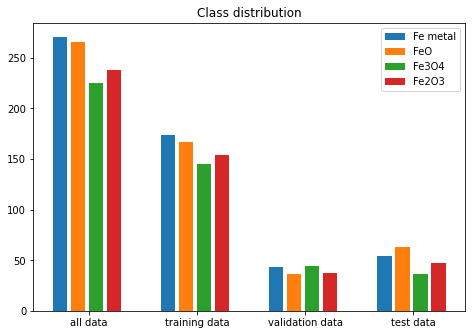

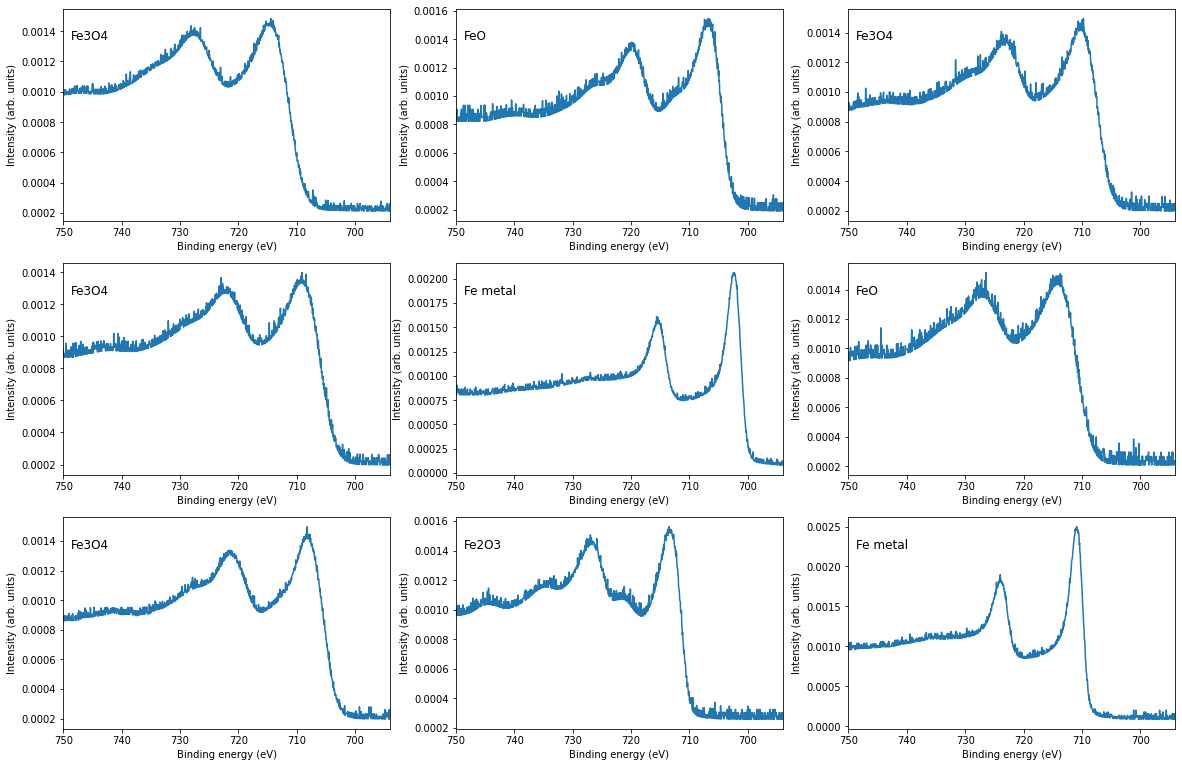

In [47]:
input_filepath = r'/content/drive/My Drive/app/datasets/20200605_iron_single_small.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 1000

X_train, X_val, X_test, y_train, y_val, y_test = clf.load_data_preprocess(input_filepath = input_filepath,
                                                                          no_of_examples = no_of_examples,
                                                                          train_test_split = train_test_split,
                                                                          train_val_split = train_val_split)
# Check how the examples are distributed across the classes:
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 9, dataset = 'train')  

## Load pre-trained model

### Load model without classification layers

In [51]:
clf.load_model(model_path = r'/content/drive/My Drive/app/saved_models/20200629_23h27m_Fe_single_4_classes',
               drop_last_layers = 2)
clf.summary()

Loaded model from disk.
The last 2 layers were dropped.

Model: "Changed_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1121, 4)      24          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1121, 4)      44          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1121, 4)      64          input_2[0][0]                    
_____________________________

In [53]:
clf.load_model(model_path = r'/content/drive/My Drive/app/saved_models/20200629_23h27m_Fe_single_4_classes')

Loaded model from disk.


In [54]:
clf.model.get_config().keys()

clf.model.get_config()['input_layers']
clf.model.get_config()['output_layers']
#self.model.get_config()['no_of_inputs'],


tensorflow.python.keras.engine.training.Model

dict_keys(['name', 'layers', 'input_layers', 'output_layers'])

[['input_2', 0, 0]]

[['dense_3', 0, 0]]

### Freeze the feature extractor

In [ ]:
clf.model.trainable = False


### Add new classification layers

In [ ]:
from tensorflow.keras.layers import Dense

dense_1 = Dense(1000, activation = 'relu')(clf_2.model.layers[-1].output)
dense_2 = Dense(clf.num_classes, activation = 'softmax')(dense_1)
clf.model = models.EmptyModel(inputs = clf.model.input,
                        outputs = dense_2,
                        inputshape = clf.input_shape,
                        num_classes = clf.num_classes,
                        no_of_inputs = clf.model.get_config()['no_of_inputs'],
                        name = 'Changed_Model')
clf.summary()

### Compile and summarize the model

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 

clf.model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer, 
                  metrics = ['accuracy'])


# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Training

In [ ]:
epochs = 10
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

### Graphs

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name) 
graph.plot_loss()
graph.plot_accuracy()

### Evaluation on test data

In [ ]:
score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]
print('Test loss: ' + str(np.round(test_loss, decimals=3)))
print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

### Prediction on test data

In [ ]:
pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()

### Show some predictions

#### Training data

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  

#### Test data

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

### Saving data

In [ ]:
clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

### Report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

### Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"), include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time

save_notebook()
time.sleep(3)
current_file = 'transfer_learning.ipynb'
output_file = os.path.join(clf.log_dir,'transfer_learning_out.html')
output_HTML(current_file, output_file)